## Error Mitigation and Error Correction for Noisy Pulse sequence (4 qubit system)

In [3]:
#Execute this code block to ensure the subsequent code executes well.
!pip install qiskit >/dev/null
!pip install -U qiskit-aer >/dev/null
!pip install pylatexenc >/dev/null
!pip install qiskit-ignis >/dev/null

In [4]:
#Required libraries
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from qiskit import QuantumCircuit, transpile, execute, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer, plot_histogram
from qiskit import pulse
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeWashington, FakeBackendV2
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

from itertools import product
from collections import Counter

## Creation of Pulse sequence

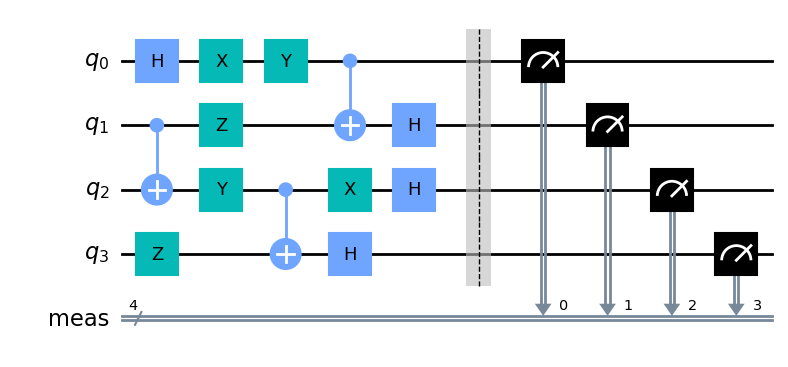

In [19]:
# ========= CIRCUIT WITHOUT THREE-BIT CODE ERROR CORRECTION ===========

# A 4 qubit system with multiple gates including pauli's exclusion gates, hadamard and others.
circ = QuantumCircuit(4)

circ.h(0)
circ.x(0)

circ.z(3)

circ.y(0)
circ.cx(1, 2)

circ.z(1)
circ.cx(0, 1)
circ.y(2)
circ.cx(2, 3)
circ.x(2)
circ.h(1)
circ.h(2)
circ.h(3)

circ.measure_all()

circ.draw('mpl', idle_wires=False)

## Pre-measurement Error Correction: Three-Bit Code

- Upon transmission of a single-qubit state, a random $\sigma_{x}$ error can be introduced

- Employ 4 qubits to correct errors for each qubit

- We've **turned off** three-bit code error correction due to transpilation in error mitigation

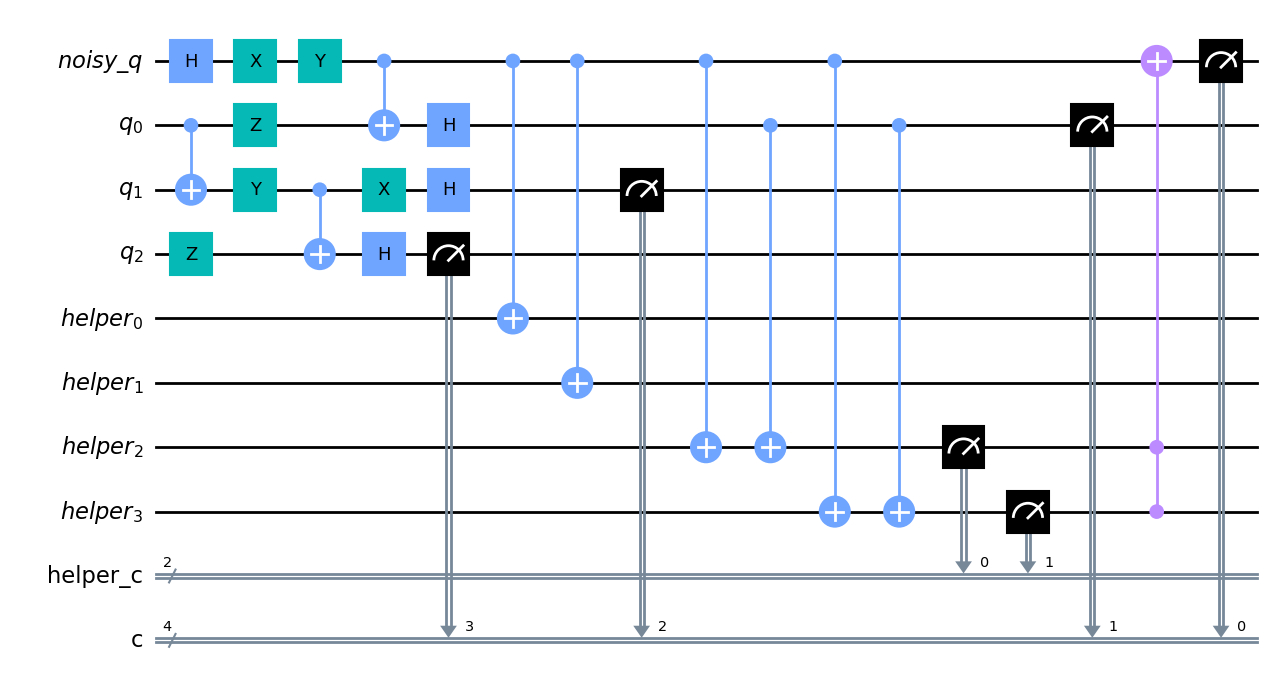

In [ ]:
'''
# ========= CIRCUIT WITH THREE-BIT CODE ERROR CORRECTION ===========

noisy_q = QuantumRegister(1, 'noisy_q')
q = QuantumRegister(3, 'q')
helper = QuantumRegister(4, 'helper')
c_helper = ClassicalRegister(2, 'helper_c')
c = ClassicalRegister(4, 'c')
circ = QuantumCircuit(noisy_q, q, helper, c_helper, c)

# random circuit

circ.h(0)
circ.x(0)

circ.z(3)

circ.y(0)
circ.cx(1, 2)

circ.z(1)
circ.cx(0, 1)
circ.y(2)
circ.cx(2, 3)
circ.x(2)
circ.h(1)
circ.h(2)
circ.h(3)

# error correction: three bit code
circ.cx(0, 4)
circ.cx(0, 5)

circ.cx(0, 6)
circ.cx(1, 6)
circ.cx(0, 7)
circ.cx(1, 7)

# if helper qubits are in |11>, apply X gate to the noisy qubit
circ.measure(6, c_helper[0])
circ.measure(7, c_helper[1])

circ.ccx(6, 7, 0)

# measurements
circ.measure(noisy_q, c[0])
circ.measure(q, c[1:4])

circ.draw('mpl', idle_wires=False)
'''

## Addition of Noise

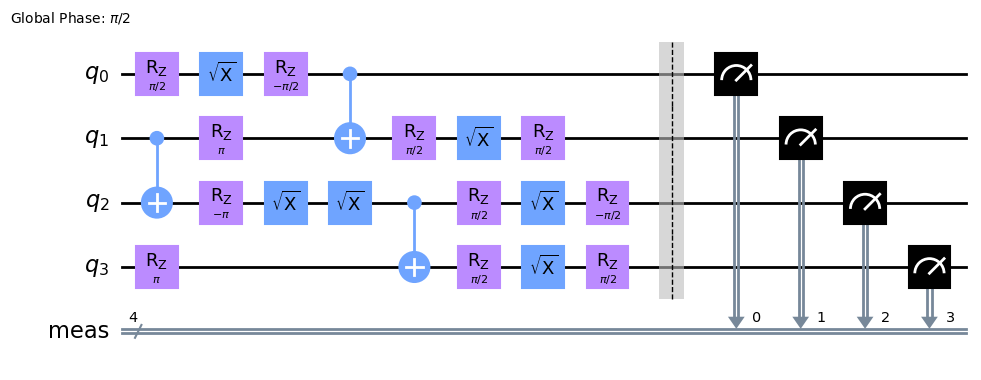

In [7]:
"""Addition of noisy state to the earlier created 4 qubit system.
We have introduced a custom depolarising error on one qubit in the system.
The error is
"""
# Error probabilities
prob_1 = 0.0001
prob_2 = 0.0001

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 1)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1'])
noise_model.add_all_qubit_quantum_error(error_2, ['u3'])

noise_model = noise.NoiseModel()

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=None,
                       basis_gates=basis_gates)
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

transpiled_circuit.draw('mpl', idle_wires=False)

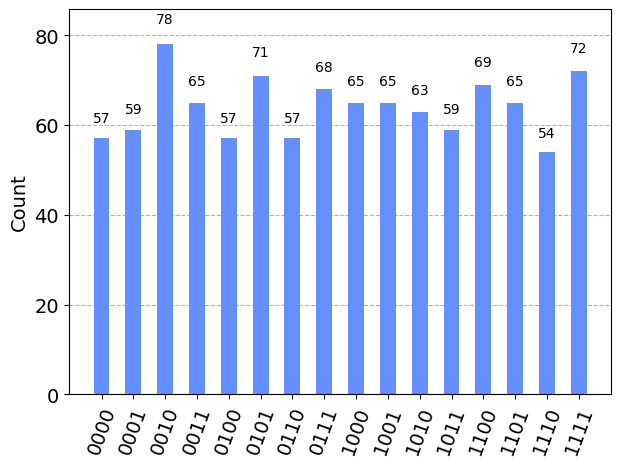

In [8]:
counts = result.get_counts(0)
plot_histogram(counts)

#Calibration of pulse sequence using Gaussian curve

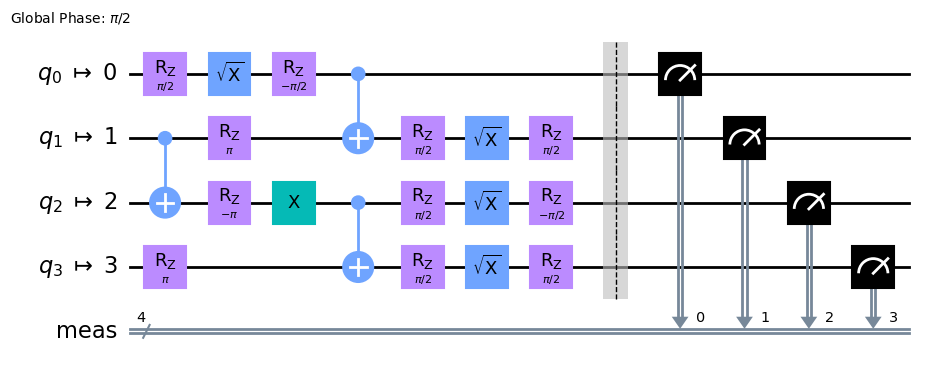

In [9]:
"""Adding calibration into the system.
Pulse gates allow you to map a logical circuit gate (e.g., X) to a Qiskit Pulse program, called a Schedule. This mapping is referred to as a calibration.
A high fidelity calibration is one which faithfully implements the logical operation it is mapped from (e.g., whether the X gate calibration drives |0> to |1>, etc.).
In our case, we calibrate the pulse schedule using a gaussian curve ( We configure the amplitude, duration and other parameters)"""
#A n>8 qubit backend to support our circuit system.
backend = FakeWashington()
with pulse.build(backend, name='custom') as schedule:
    pulse.play(Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0))

#Calibration on pulse using a pauli's Z
circ.add_calibration('z', [1], schedule)

circ = transpile(transpiled_circuit, backend)
circ.draw('mpl', idle_wires=False)

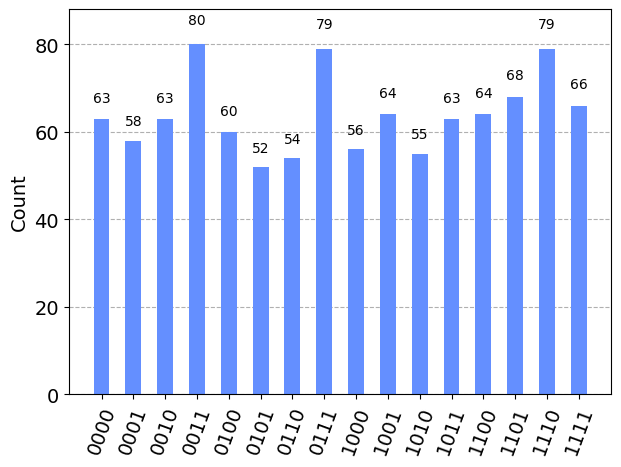

In [10]:
result = backend.run(circ).result()
counts = result.get_counts(0)
plot_histogram(counts)

# Uhrig Dynamical Decoupling
We implement Uhrig's sequence, which is a modification of a sine wave pulse, on qubit 0 in your quantum circuit. This sequence helps reduce errors caused by noise and decoherence. Below, you see that - the error mitigation techniques, in conjunction with Uhrig's sequence, lead to improved results, reduced errors, and increased reliability in quantum computation.

Citation: Biercuk, Michael & Uys, Hermann & Vandevender, Aaron & Shiga, Nobuyasu & Itano, Wayne & Bollinger, John. (2009). Experimental Uhrig Dynamical Decoupling using Trapped Ions. Physical Review A. 79. 10.1103/PhysRevA.79.062324.

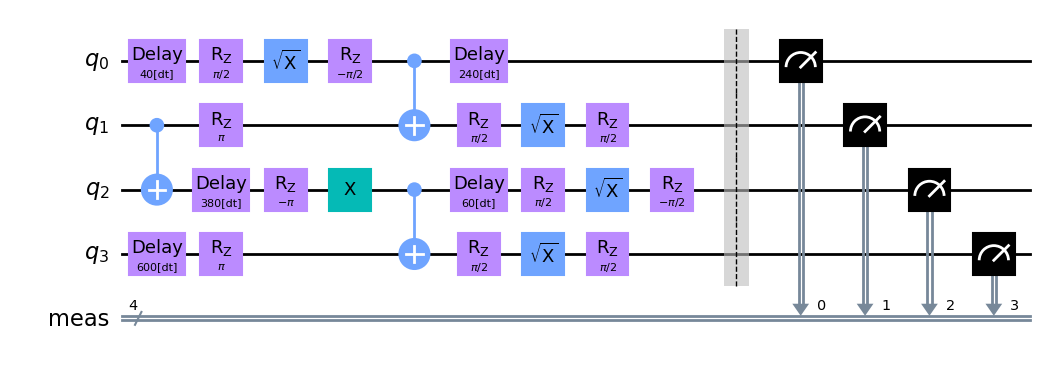

In [12]:
#Decoupling based on uhrig qubit.
durations = InstructionDurations(
    [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300),("rz", [4], 50), ("sx", 4, 80), ("rz", [3], 80), ("sx", 3, 80) ,("cx", [3, 4], 200),("rz", [1], 80),("sx", 1, 80),("cx", [2,1], 300), ("cx", [1,3], 600),("rz", [2], 50),("sx", 2, 80),("sx", 0, 80),
     ("x", None, 50), ("measure", None, 1000), ("h", 1, 50), ("h", 3, 50), ("h", 2, 50), ("z", 1, 100), ("z", 3, 100), ("y", 1, 100), ("y", 2, 100), ("y", 0, 100), ("rz", [0], 80)]
)

def pass_manager_uhrig_qubit(circ):

    # Uhrig sequence on qubit 0
    n = 6
    dd_sequence = [XGate()] * n

    def uhrig_pulse_location(k):
        return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
    spacing = []

    for k in range(n):
        spacing.append(uhrig_pulse_location(k) - sum(spacing))

    spacing.append(1 - sum(spacing))
    circ.draw('mpl')
    pm = PassManager(
        [
            ALAPSchedule(durations),
            DynamicalDecoupling(durations, dd_sequence, qubits=[0], spacing=spacing),
        ]
    )
    circ_dd = pm.run(circ)
    timeline_drawer(circ_dd)
    return circ_dd

circ_dd = pass_manager_uhrig_qubit(circ)
circ_dd.draw('mpl', idle_wires=False)

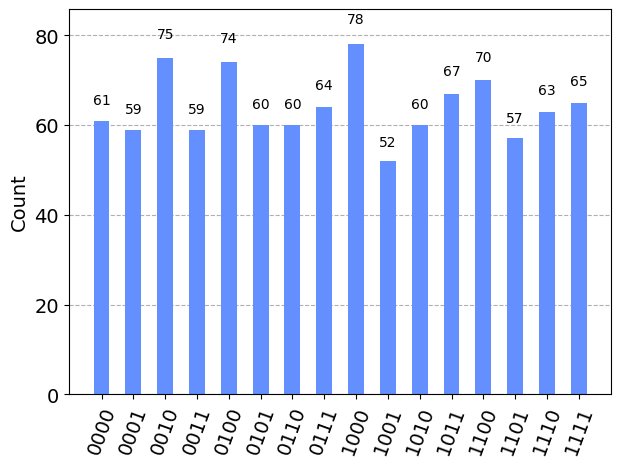

In [13]:
result = backend.run(circ_dd).result()

counts = result.get_counts(0)
plot_histogram(counts)

## Post-measurement Error Correction: HAMMER

- Dominant incorrect outcomes that appear with high frequency are
close to the correct answers in Hamming space

- First, identify the Hamming distance neighborhood for each unique outcome in the histogram

- Second, analyzes the
neighborhood scores of all unique outcomes to develop a weight

- Third, use the weight and the probability distribution of the neighborhood to compute the effective value for each
outcome in the probability distribution



>>
Swamit Tannu, Poulami Das, Ramin Ayanzadeh, and Moinuddin Qureshi. 2022. HAMMER: boosting fidelity of noisy Quantum circuits by exploiting Hamming behavior of erroneous outcomes. In Proceedings of the 27th ACM International Conference on Architectural Support for Programming Languages and Operating Systems (ASPLOS '22). Association for Computing Machinery, New York, NY, USA, 529–540. https://doi.org/10.1145/3503222.3507703



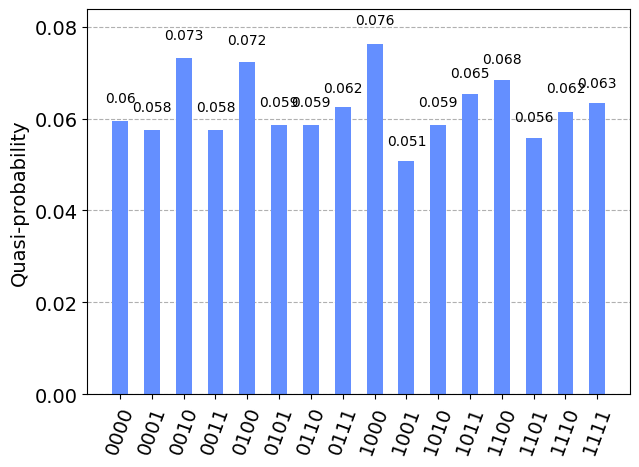

In [14]:
# normalize the result

total_count = sum(counts.values())
probability_distribution = {key: value / total_count for key, value in counts.items()}
plot_histogram(probability_distribution)

# Error correction using Hammer

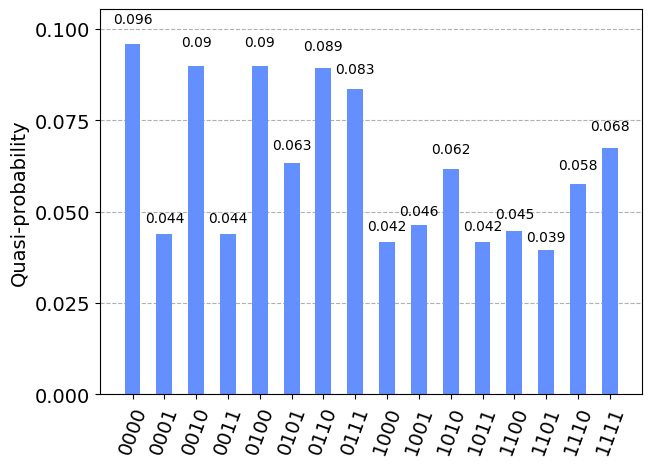

In [ ]:
# hamming weights
hamming_weights = {0:0.5, 1:0.01, 2:-0.05, 3:-0.1, 4:-0.2}

# calculate hamming distance by comparing each bit
def hamming_distance(str1, str2):
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

# generate hamming distance groups for a binary string
def group_by_hamming_distance(binary_string):
    all_binary_strings = [''.join(item) for item in product('01', repeat=len(binary_string))]

    distance_dict = {}
    for b_str in all_binary_strings:
        distance = hamming_distance(binary_string, b_str)
        if distance in distance_dict:
            distance_dict[distance].append(b_str)
        else:
            distance_dict[distance] = [b_str]

    return distance_dict

# update probabilities using the weight and the probability distribution of the neighborhood
def update_probabilty(probability_distribution):
    new_dict = {}

    for bin, prob in probability_distribution.items():
        groups = group_by_hamming_distance(bin)
        update_prob = prob

        for distance, group in groups.items():
            for string in group:
                # update possibility based on the hamming distance and weights
                # print(bin, distance, string, probability_distribution[string])
                update_prob += hamming_weights[distance] * probability_distribution[string]

        new_dict[bin] = update_prob
        # print(prob, update_prob)

    # normalize
    total_count = sum(new_dict.values())
    new_prob = {key: value / total_count for key, value in new_dict.items()}

    return new_prob

res = update_probabilty(probability_distribution)

plot_histogram(res)